In [1]:
# Importing required libraries
import re, ast
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
RANDOM_STATE = 42

# Setting the style of the plots
sns.set_style("whitegrid")

In [2]:
# Winsorisation percentiles
PRICE_LOW_PCT  = 0.01
PRICE_HIGH_PCT = 0.995
MILE_LOW_PCT   = 0.001
MILE_HIGH_PCT  = 0.995

In [3]:
# Setting the model parameters
RF_ESTIMATORS = 100
RF_NJOBS = 1
GBR_ESTIMATORS = 100

In [4]:
# loading the dataset
df = pd.read_csv('cars_dataframe.csv')

In [5]:
# Display column names
print(df.columns)

Index(['Brand', 'Model', 'Year', 'Condition', 'Mileage', 'Gearbox',
       'Fiscal Power', 'Fuel', 'Equipment', 'Number of Doors', 'Origin',
       'First Owner', 'Location', 'Sector', 'Price'],
      dtype='object')


In [6]:
# Printing total rows and columns
print(f"Total rows: {df.shape[0]}")
print(f"Total columns: {df.shape[1]}")

Total rows: 101896
Total columns: 15


In [7]:
# Display head of data
df.head()

,Brand,Model,Year,Condition,Mileage,Gearbox,Fiscal Power,Fuel,Equipment,Number of Doors,Origin,First Owner,Location,Sector,Price
0,Volkswagen,Polo,1997,Good,200 000 - 249 999,Manual,8 CV,Diesel,"['Leather Seats', 'CD/MP3/Bluetooth']",NaN,NaN,NaN,Tétouan,City Center,27000.0
1,Dacia,Sandero,2012,Very Good,180 000 - 189 999,Manual,6 CV,Diesel,"['Rear Camera', 'Electric Windows']",5.0,WW in Morocco,No,Temara,City Center,69000.0
2,Volkswagen,Polo,2004,Fair,300 000 - 349 999,Manual,8 CV,Diesel,"['Alloy Wheels', 'Electric Windows']",5.0,WW in Morocco,No,Safi,Chenguite,45000.0
3,Bentley,Continental gtc,2009,Excellent,45 000 - 49 999,Automatic,34 CV,Petrol,"['Rear Camera', 'Electric Windows']",3.0,Customs-cleared car,Yes,Casablanca,Aïn Chock,720000.0
4,mini,cooper,2013,Excellent,85 000 - 89 999,Automatic,8 CV,Diesel,"['Airbags', 'CD/MP3/Bluetooth', 'Rear Camera',...",5.0,WW in Morocco,No,Fès,Agdal,128000.0


In [8]:
# Printing the types of data columns
print(df.dtypes)

Brand               object
Model               object
Year                object
Condition           object
Mileage             object
Gearbox             object
Fiscal Power        object
Fuel                object
Equipment           object
Number of Doors    float64
Origin              object
First Owner         object
Location            object
Sector              object
Price              float64
dtype: object


In [9]:
# Normalising and cleaning column names
df.columns = [c.strip() for c in df.columns]
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

In [10]:
# cleaning Mileage by removing 'km', commas, spaces, and converting to numeric
def clean_mileage(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float)):
        return x
    s = str(x)
    # to extract first number-like token
    s = s.replace('km','').replace('KM','').replace('Km','')
    s = s.replace(',', '').replace(' ', '')
    # handle lists or other formats by removing brackets
    s = s.strip("[]()")
    # if there are multiple values separated by ';' or '|' or '/'
    for sep in [';', '|', '/']:
        if sep in s:
            s = s.split(sep)[0]
    # keep only digits
    filtered = ''.join(ch for ch in s if (ch.isdigit() or ch=='.'))
    if filtered=='':
        return np.nan
    try:
        return float(filtered)
    except:
        return np.nan

df['Mileage'] = df['Mileage'].apply(clean_mileage)

In [11]:
# cleaning Fiscal Power by removing 'CV' and non-numeric parts
def clean_fiscal(x):
    if pd.isna(x):
        return np.nan
    s = str(x)
    s = s.replace('CV','').replace('cv','').replace(' ','').replace(',', '')
    filtered = ''.join(ch for ch in s if (ch.isdigit() or ch=='.' or ch=='-'))
    if filtered=='':
        return np.nan
    try:
        return float(filtered)
    except:
        return np.nan

df['Fiscal Power'] = df['Fiscal Power'].apply(clean_fiscal)

In [12]:
# Checking for missing values
missing_values = df.isnull().sum()
print(missing_values)

Brand                  1
Model                  1
Year                 307
Condition           3583
Mileage                1
Gearbox                0
Fiscal Power         280
Fuel                   0
Equipment              0
Number of Doors    11415
Origin             11975
First Owner        14700
Location               0
Sector               246
Price              25483
dtype: int64


In [13]:
# Defining a function to perform parsing
def Parse_number_flex(s):
    if pd.isna(s):
        return np.nan
    s = str(s).strip()
    # French "Plus de 500 000" to take the number
    if re.search(r'(?i)plus de', s) or re.search(r'(?i)moins de', s):
        nums = re.findall(r'[\d\.,]+', s)
        if nums:
            return float(nums[0].replace(' ', '').replace(',', ''))
    # ranges like "10-20" or "10 à 20"
    if re.search(r'[-–—]', s) or re.search(r'\bà\b', s):
        nums = re.findall(r'[\d\.,]+', s)
        if len(nums) >= 2:
            vals = [float(n.replace(' ', '').replace(',', '')) for n in nums[:2]]
            return float(np.mean(vals))
    # remove non-number characters but keep e/E for scientific notation
    s2 = re.sub(r'[^\d\.\,eE\-]', '', s)
    # ambiguous comma to remove commas
    s3 = s2.replace(' ', '').replace(',', '')
    try:
        return float(s3)
    except:
        try:
            return float(s2)
        except:
            return np.nan

In [14]:
# Parsing price and mileage and fiscal power
df['Price_parsed'] = df['Price'].apply(Parse_number_flex)
df['Mileage_parsed'] = df['Mileage'].apply(Parse_number_flex)
if 'Fiscal Power' in df.columns:
    df['Fiscal Power_parsed'] = df['Fiscal Power'].apply(Parse_number_flex)
else:
    df['Fiscal Power_parsed'] = np.nan

In [15]:
# Ensuring that Year is numeric
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

In [16]:
# Verifying the parsed prices and mileage
print("parsed prices count:", df['Price_parsed'].notna().sum())
print("parsed mileage count:", df['Mileage_parsed'].notna().sum())

parsed prices count: 76413
parsed mileage count: 101895


In [17]:
# Filtering and Winsorizing extremes at percentiles to remove garbage extremes
p_low = df['Price_parsed'].quantile(PRICE_LOW_PCT)
p_high = df['Price_parsed'].quantile(PRICE_HIGH_PCT)
m_low = df['Mileage_parsed'].quantile(MILE_LOW_PCT)
m_high = df['Mileage_parsed'].quantile(MILE_HIGH_PCT)

print("price winsor lower:", p_low, "upper:", p_high)
print("mileage winsor lower:", m_low, "upper:", m_high)

price winsor lower: 10500.0 upper: 1111111.0
mileage winsor lower: 4999.0 upper: 400000449999.0


In [18]:
# Creating winsorized columns
df['Price_winsor'] = df['Price_parsed'].clip(lower=p_low, upper=p_high)
df['Mileage_winsor'] = df['Mileage_parsed'].clip(lower=m_low, upper=m_high)

In [19]:
# Dropping missing critical fields
df = df.dropna(subset=['Price_winsor','Mileage_winsor','Year']).copy()
print("shape after keeping rows with parsed price+mileage+year:", df.shape)

shape after keeping rows with parsed price+mileage+year: (76225, 20)


In [20]:
# Dropping any remaining rows with critical numeric NaNs
df = df.dropna(subset=['Mileage','Fiscal Power','Number of Doors','Origin','First Owner','Sector','Condition','Price','Year']).copy()

In [21]:
# Verifying missing values
df.isnull().sum()

,0
Brand,0
Model,0
Year,0
Condition,0
Mileage,0
Gearbox,0
Fiscal Power,0
Fuel,0
Equipment,0
Number of Doors,0


In [22]:
# Verifying last preprocessed shape of data
df.shape

(59707, 20)

In [23]:
# Display tail of data
df.tail()

,Brand,Model,Year,Condition,Mileage,Gearbox,Fiscal Power,Fuel,Equipment,Number of Doors,Origin,First Owner,Location,Sector,Price,Price_parsed,Mileage_parsed,Fiscal Power_parsed,Price_winsor,Mileage_winsor
101889,Ford,Focus,2007.0,Very Good,2.000002e+11,Manual,7.0,Diesel,"['ABS', 'CD/MP3/Bluetooth', 'Air Conditioning'...",5.0,Customs-cleared car,No,Salé,Hay Oued Dahab,77000.0,77000.0,2.000002e+11,7.0,77000.0,2.000002e+11
101891,Suzuki,Celerio,2011.0,Very Good,1.900002e+11,Manual,5.0,Petrol,"['Airbags', 'CD/MP3/Bluetooth', 'Air Condition...",5.0,WW in Morocco,No,Tétouan,Old Medina,55000.0,55000.0,1.900002e+11,5.0,55000.0,1.900002e+11
101892,Volkswagen,Polo,2012.0,Very Good,1.000015e+09,Manual,5.0,Diesel,"['ABS', 'Airbags', 'CD/MP3/Bluetooth', 'Air Co...",5.0,WW in Morocco,No,Casablanca,Hay Sadri,100000.0,100000.0,1.000015e+09,5.0,100000.0,1.000015e+09
101894,Honda,CR-V,2016.0,Excellent,1.400001e+11,Automatic,6.0,Diesel,"['ABS', 'Airbags', 'CD/MP3/Bluetooth', 'Rear C...",5.0,WW in Morocco,Yes,Dar Bouazza,Toute la ville,215000.0,215000.0,1.400001e+11,6.0,215000.0,1.400001e+11
101895,Volkswagen,GOLF 8,2021.0,New,5.000055e+09,Automatic,41.0,Petrol,"['Rear Camera', 'CD/MP3/Bluetooth']",5.0,Imported New,No,Casablanca,Bourgogne,450000.0,450000.0,5.000055e+09,41.0,450000.0,5.000055e+09


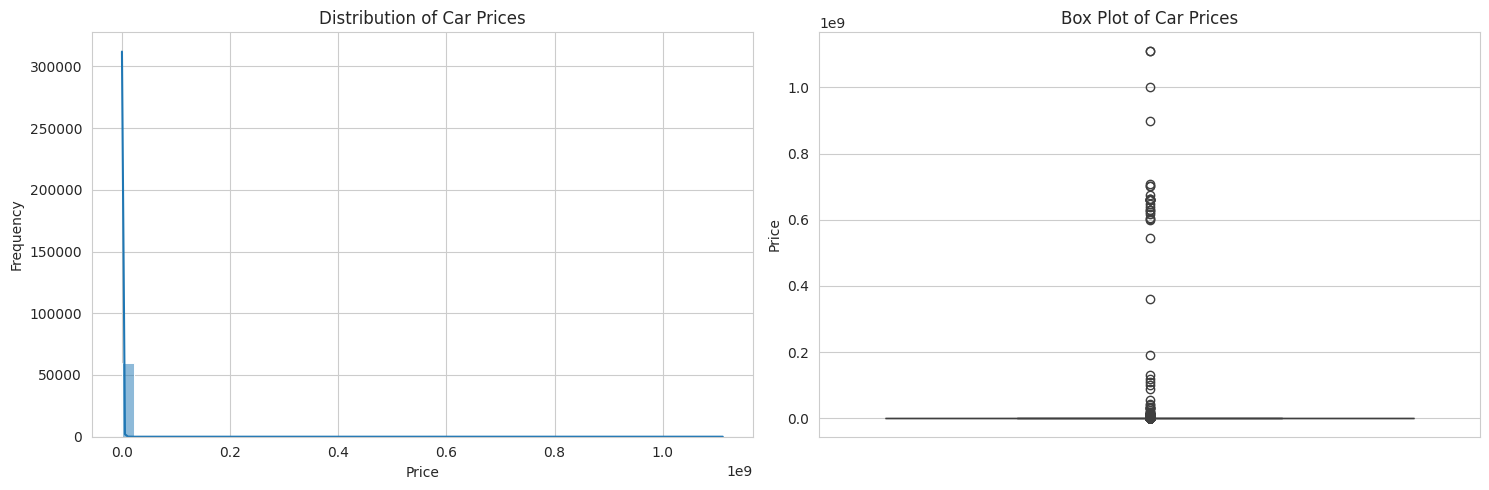

In [24]:
# Plotting the Distribution of Car Prices
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['Price'], kde=True, bins=50)
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')

# Box plot of Price
plt.subplot(1, 2, 2)
sns.boxplot(y=df['Price'])
plt.title('Box Plot of Car Prices')
plt.ylabel('Price')

plt.tight_layout()
plt.show()

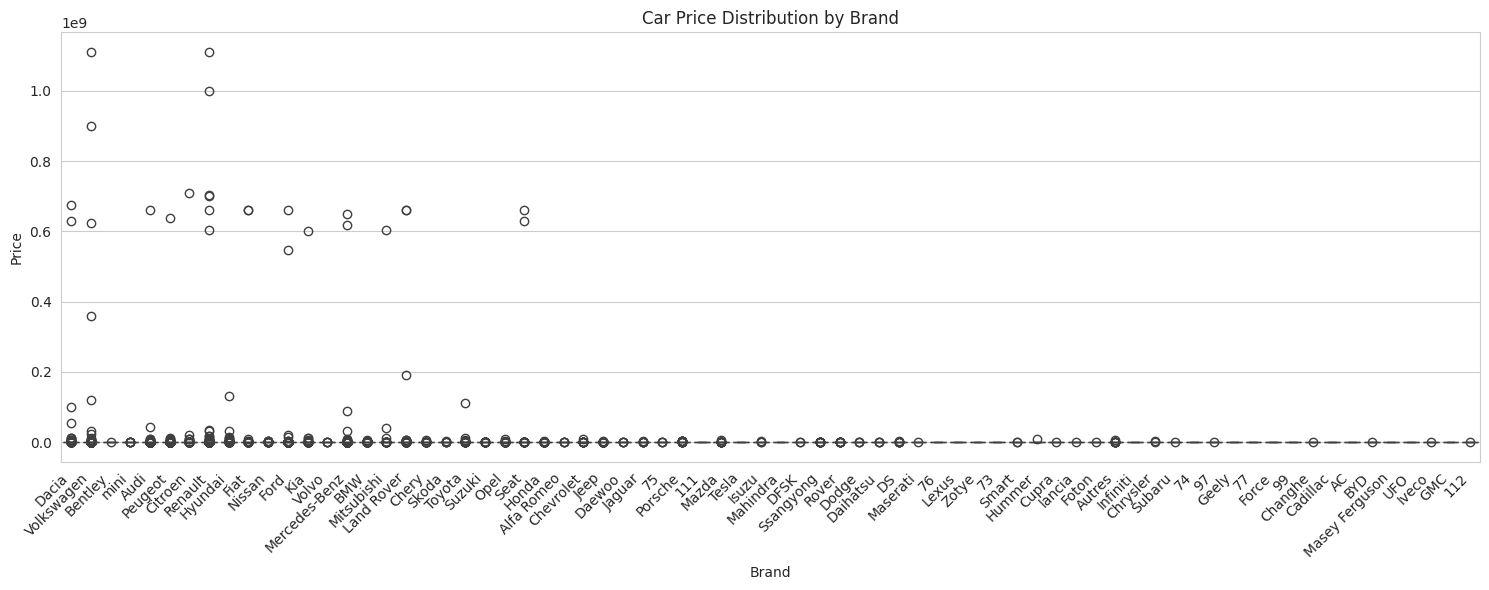

In [25]:
# Visualize the relationship between 'Brand' and 'Price'
plt.figure(figsize=(15, 6))
sns.boxplot(x='Brand', y='Price', data=df)
plt.xticks(rotation=45, ha='right')
plt.title('Car Price Distribution by Brand')
plt.xlabel('Brand')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

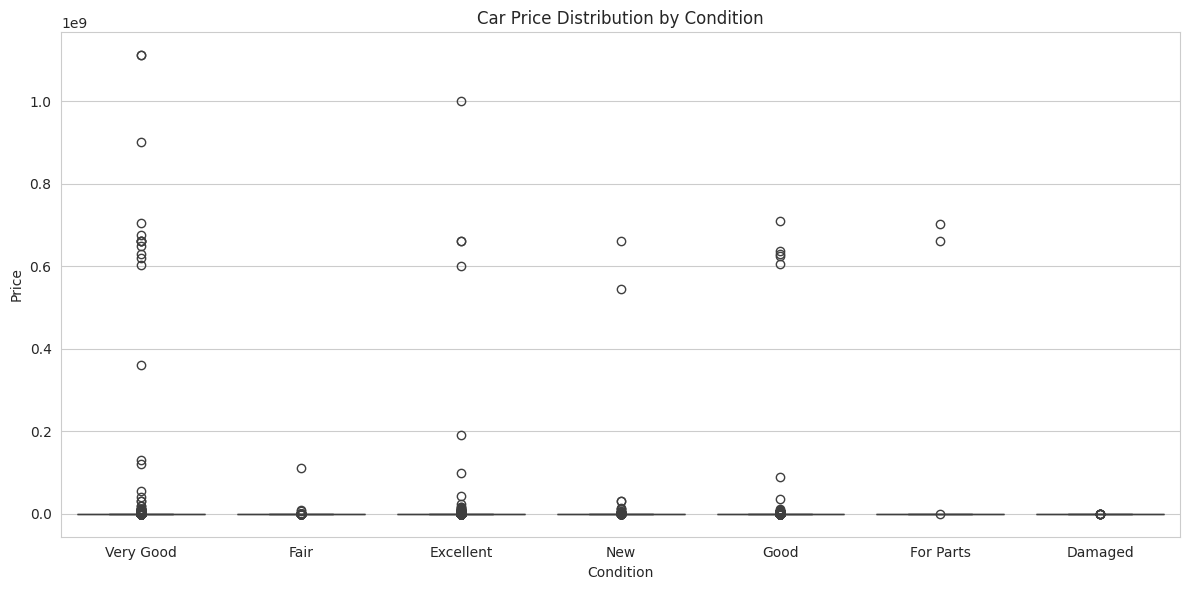

In [26]:
# Plotting Car Price Distribution by Condition
plt.figure(figsize=(12, 6))
sns.boxplot(x='Condition', y='Price', data=df)
plt.title('Car Price Distribution by Condition')
plt.xlabel('Condition')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

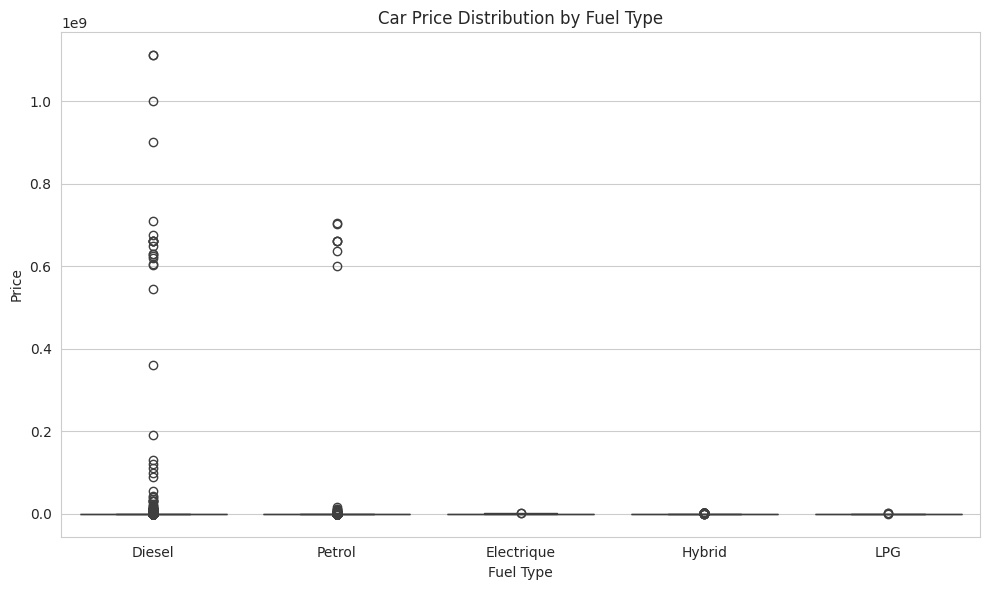

In [27]:
# Visualize the relationship between 'Fuel' and 'Price' using a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Fuel', y='Price', data=df)
plt.title('Car Price Distribution by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

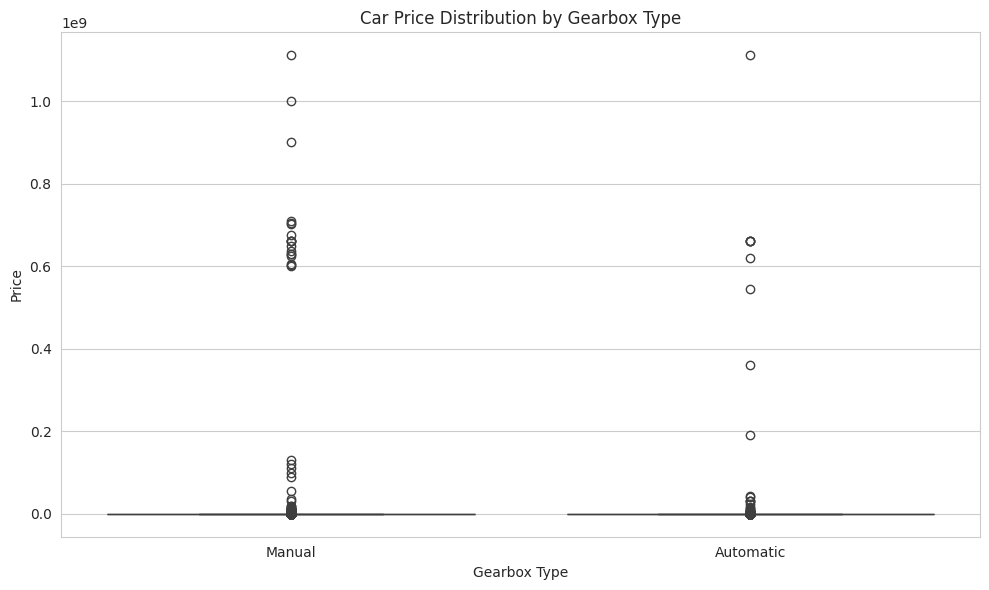

In [28]:
# Visualize the relationship between 'Gearbox' and 'Price'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Gearbox', y='Price', data=df)
plt.title('Car Price Distribution by Gearbox Type')
plt.xlabel('Gearbox Type')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

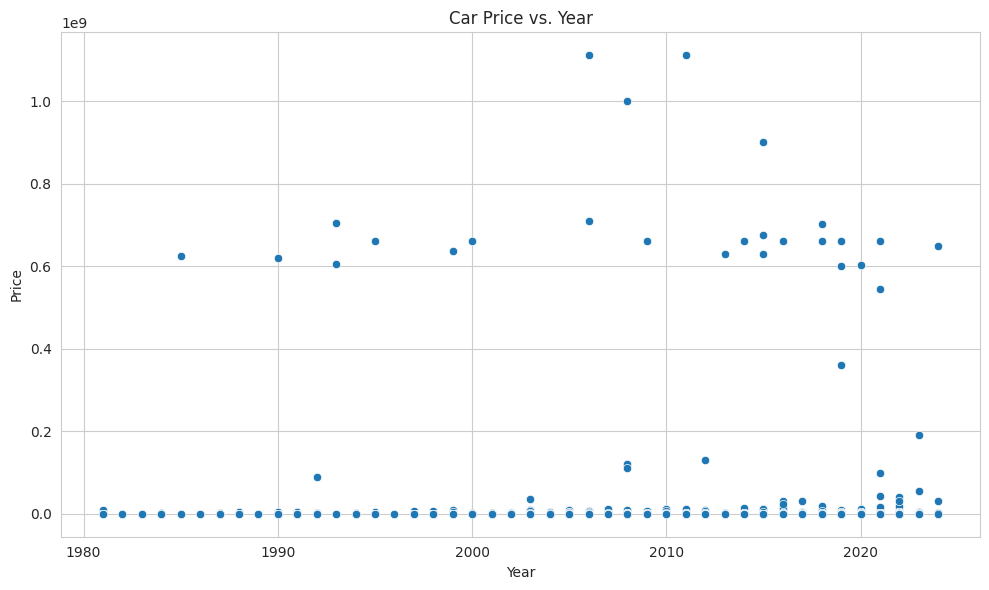

In [29]:
# Visualise a scatterplot of Car Price vs. Year
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Year', y='Price', data=df)
plt.title('Car Price vs. Year')
plt.xlabel('Year')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

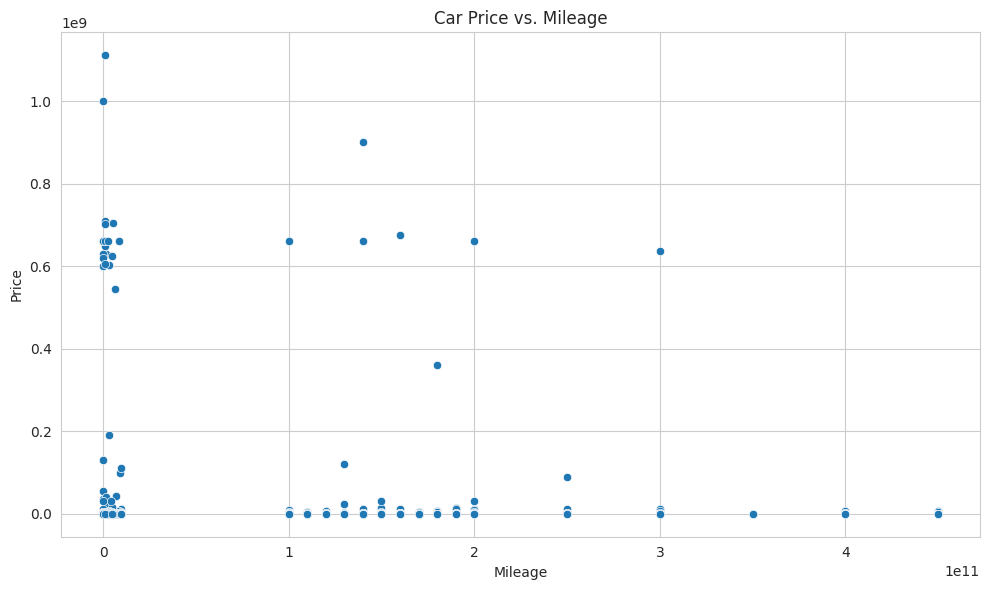

In [30]:
# Creating a scatter plot to visualize the relationship between 'Mileage' and 'Price'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Mileage', y='Price', data=df)
plt.title('Car Price vs. Mileage')
plt.xlabel('Mileage')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

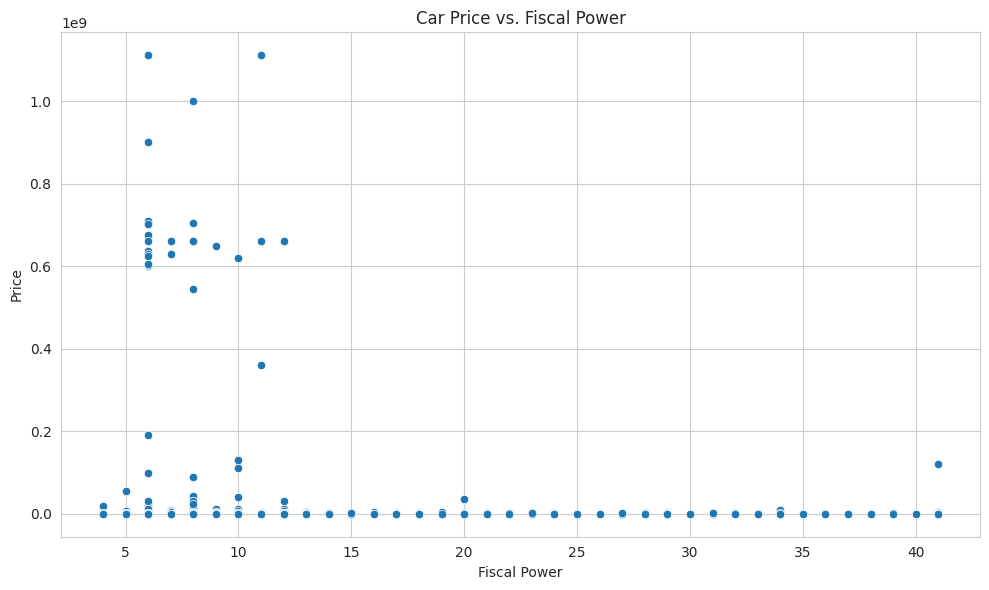

In [31]:
# Plotting a scatter plot to visualize the relationship between 'Fiscal Power' and 'Price'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Fiscal Power', y='Price', data=df)
plt.title('Car Price vs. Fiscal Power')
plt.xlabel('Fiscal Power')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

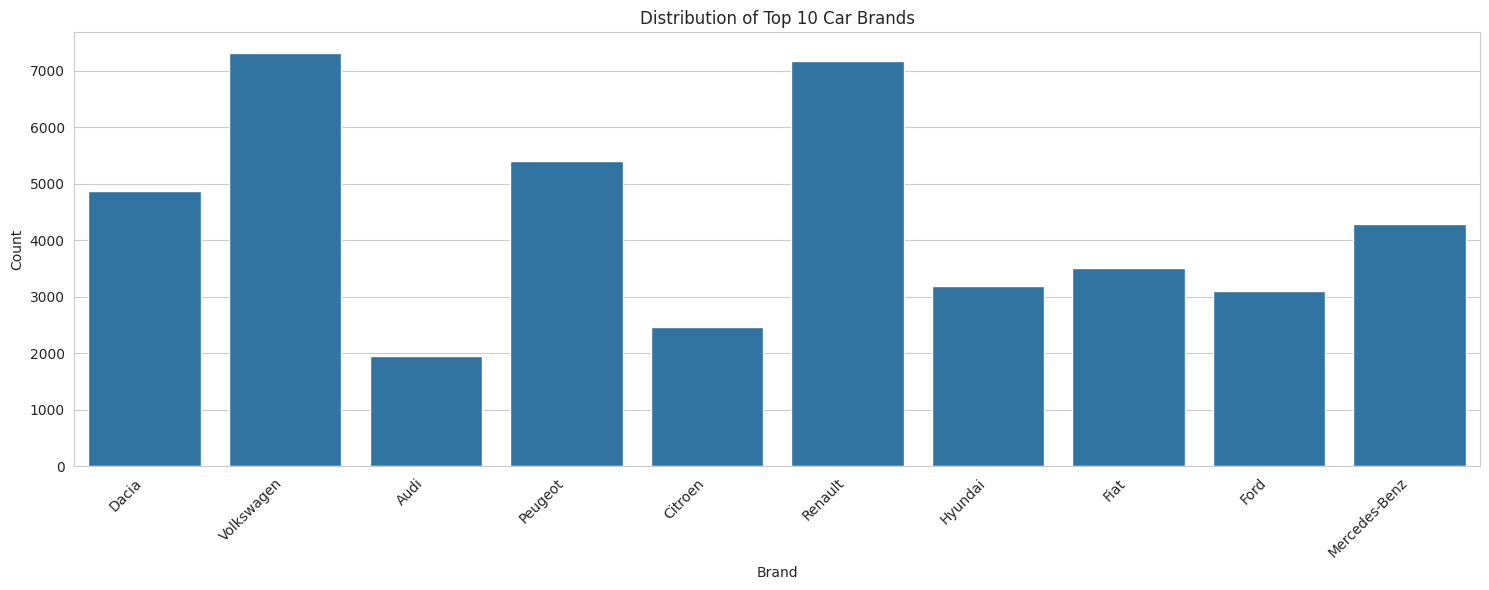

In [32]:
# Visualise the distribution of Top 10 Car Brands
top_10_brands = df['Brand'].value_counts().nlargest(10).index
plt.figure(figsize=(15, 6))
sns.countplot(x='Brand', data=df[df['Brand'].isin(top_10_brands)])
plt.title('Distribution of Top 10 Car Brands')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

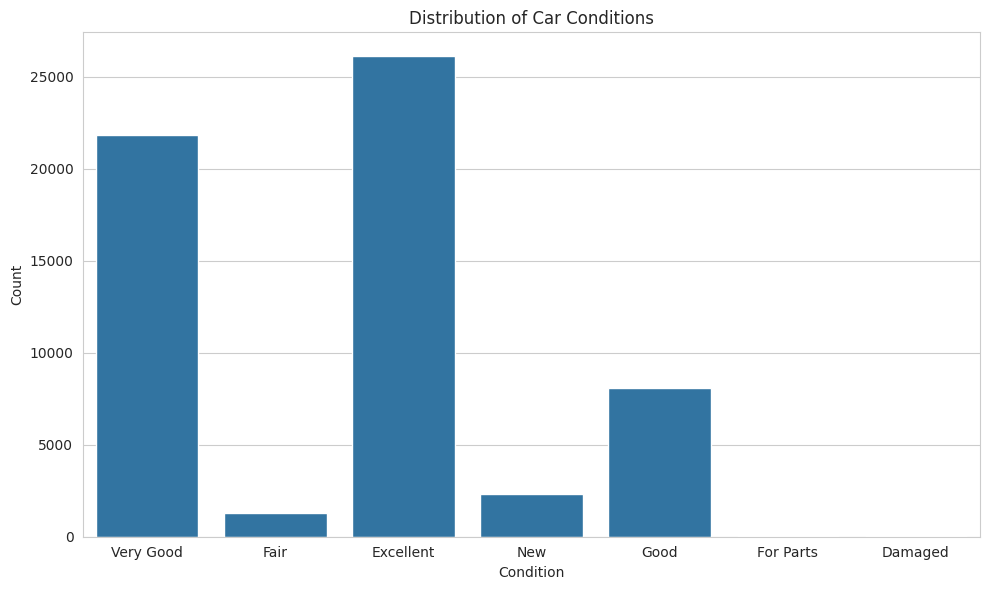

In [33]:
# Visualising the distribution of Car Conditions
plt.figure(figsize=(10, 6))
sns.countplot(x='Condition', data=df)
plt.title('Distribution of Car Conditions')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

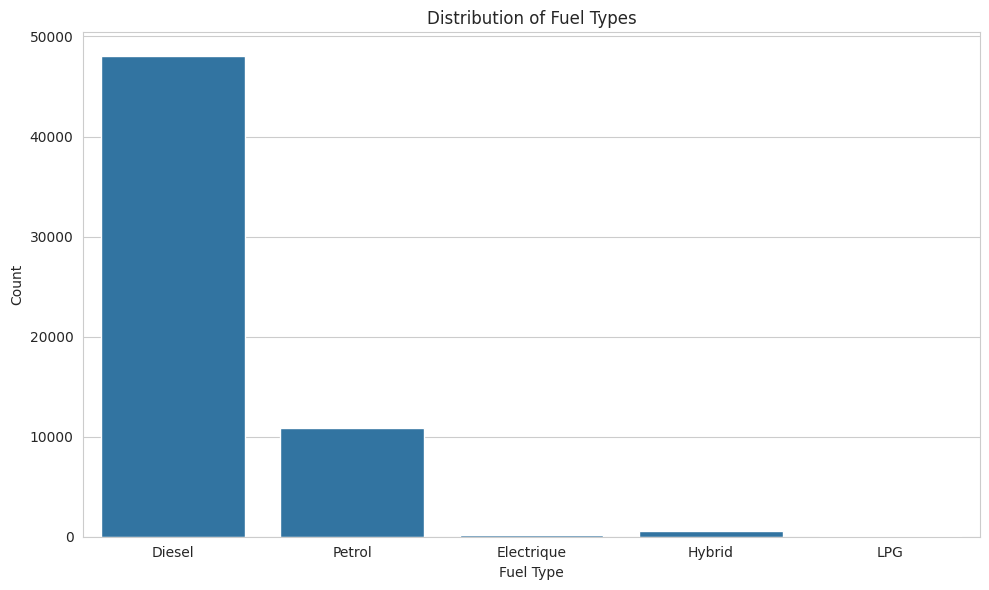

In [34]:
# Creating a count plot for Distribution of Fuel Types
plt.figure(figsize=(10, 6))
sns.countplot(x='Fuel', data=df)
plt.title('Distribution of Fuel Types')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

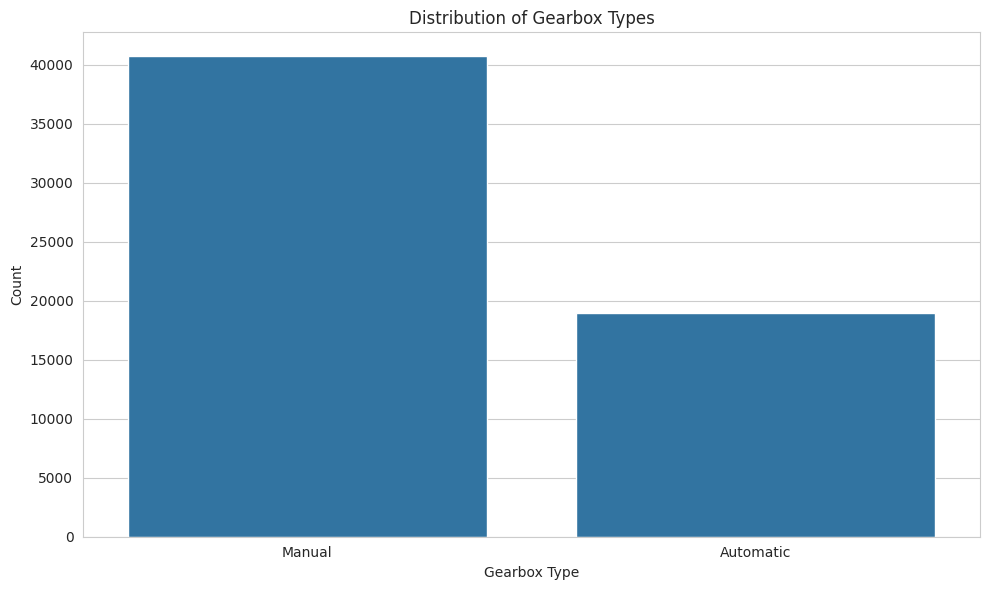

In [35]:
# Visualising a count plot for the 'Gearbox'
plt.figure(figsize=(10, 6))
sns.countplot(x='Gearbox', data=df)
plt.title('Distribution of Gearbox Types')
plt.xlabel('Gearbox Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

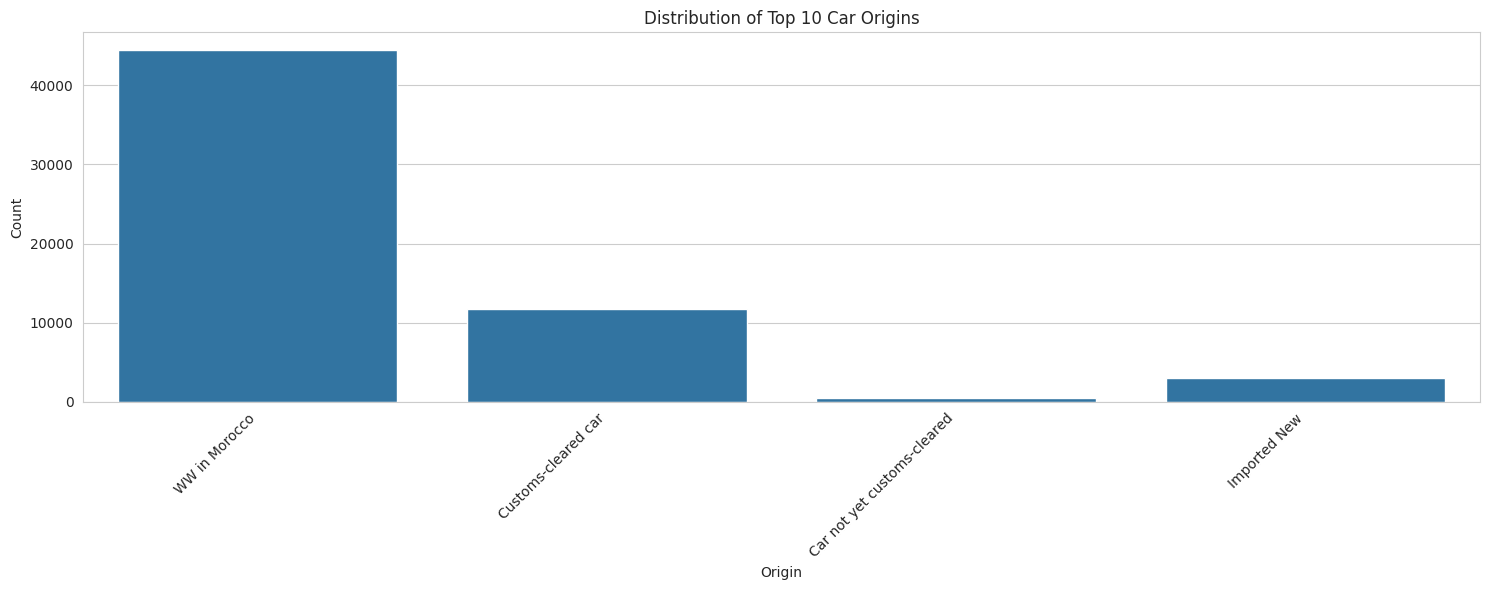

In [36]:
# Analysing the distribution of Top 10 Car Origins
top_10_origins = df['Origin'].value_counts().nlargest(10).index
plt.figure(figsize=(15, 6))
sns.countplot(x='Origin', data=df[df['Origin'].isin(top_10_origins)])
plt.title('Distribution of Top 10 Car Origins')
plt.xlabel('Origin')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

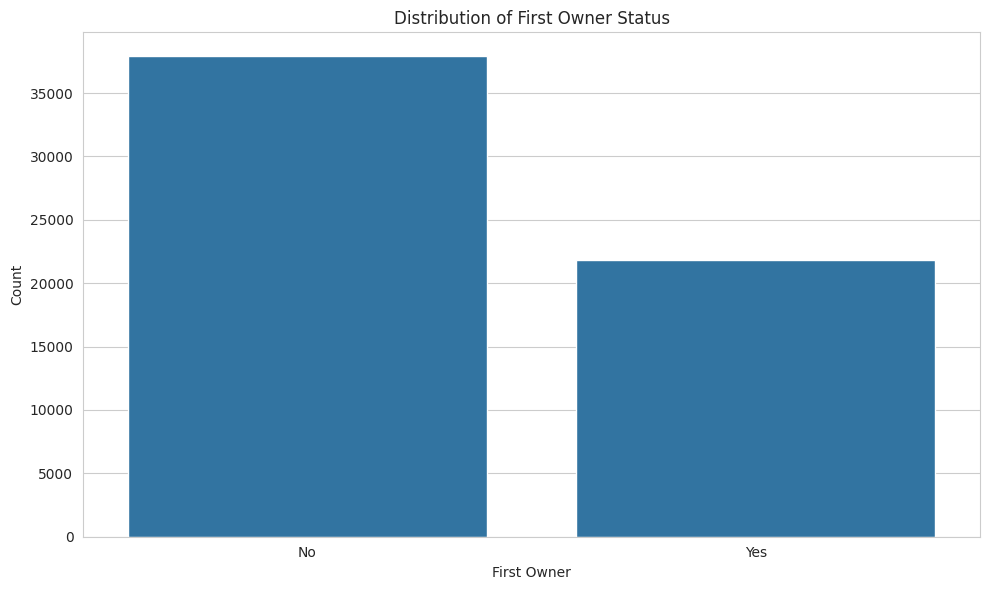

In [37]:
# Plotting the distribution of First Owner Status
plt.figure(figsize=(10, 6))
sns.countplot(x='First Owner', data=df)
plt.title('Distribution of First Owner Status')
plt.xlabel('First Owner')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

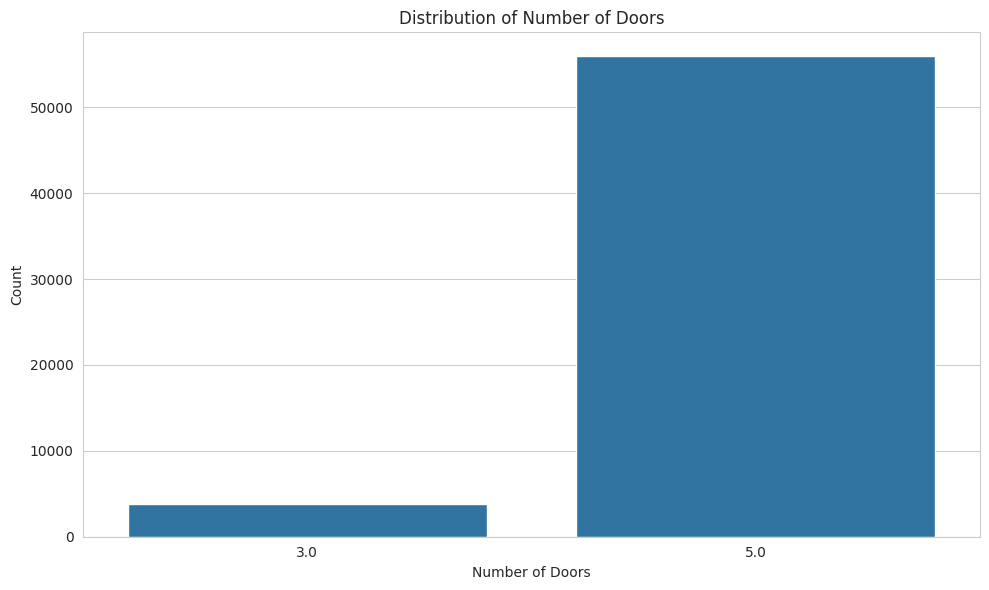

In [38]:
# Plotting a count plot for the 'Number of Doors' column
plt.figure(figsize=(10, 6))
sns.countplot(x='Number of Doors', data=df)
plt.title('Distribution of Number of Doors')
plt.xlabel('Number of Doors')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

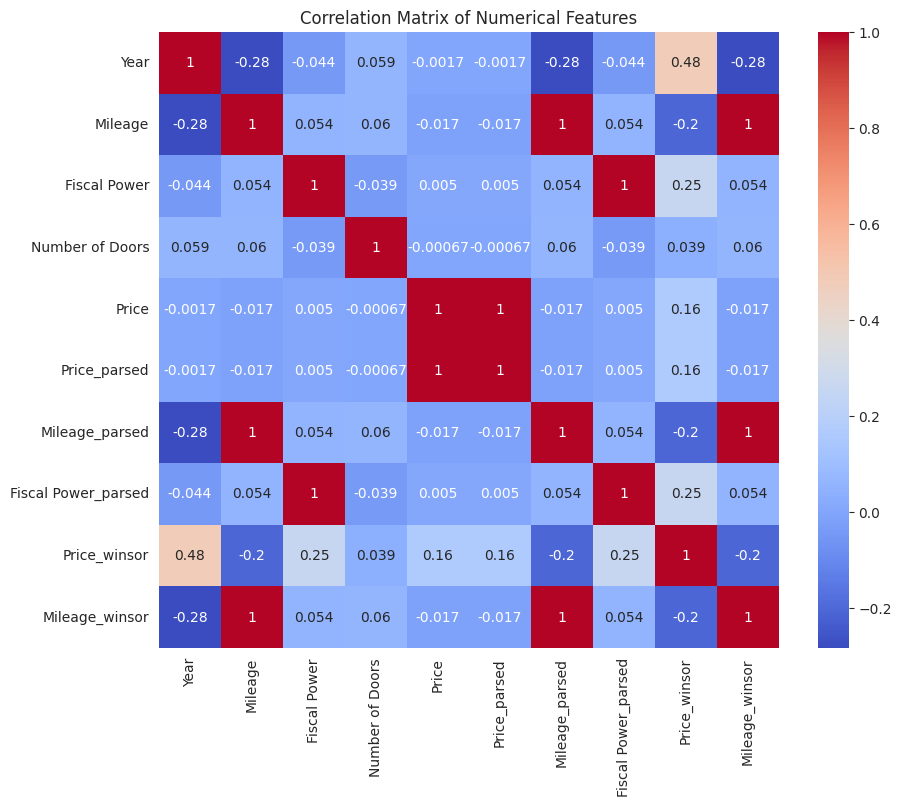

In [39]:
# Visualising a correlation matrix of the numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes(np.number).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [40]:
# Converting Price_winsor to categorical target
df['Price_Category'] = pd.qcut(df['Price_winsor'], q=3, labels=['Low', 'Medium', 'High'], duplicates='drop')

In [41]:
# Display Price category distribution
display("Price category distribution:\n", df['Price_Category'].value_counts())

'Price category distribution:\n'

,count
Price_Category,
Low,20041
Medium,20020
High,19646


In [42]:
# Performing Feature Selection
candidate_cols = ['Brand','Model','Year','Condition','Mileage_winsor','Gearbox',
                  'Fiscal Power_parsed','Fuel','Number of Doors','Origin','Location','Sector','Price_Category']

In [43]:
# Selecting the columns for the further analysis
cols = [c for c in candidate_cols if c in df.columns]
print("using columns:", cols)

using columns: ['Brand', 'Model', 'Year', 'Condition', 'Mileage_winsor', 'Gearbox', 'Fiscal Power_parsed', 'Fuel', 'Number of Doors', 'Origin', 'Location', 'Sector', 'Price_Category']


In [44]:
# Setting the features and target
X = df[[c for c in cols if c != 'Price_Category']].copy()
y = df['Price_Category'].copy()

In [45]:
# Splitting the dataset into training and testing before encoding
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y)

In [46]:
# Selecting which object cols are high-cardinality
obj_cols = X_train.select_dtypes(include='object').columns.tolist()
cardinality = {c: X_train[c].nunique() for c in obj_cols}
print("cardinality (train):", cardinality)

cardinality (train): {'Brand': 71, 'Model': 878, 'Condition': 7, 'Gearbox': 2, 'Fuel': 5, 'Origin': 4, 'Location': 342, 'Sector': 775}


In [47]:
# Setting the high-cardinality threshold
HIGH_CARD_THRESHOLD = 30
high_card = [c for c,card in cardinality.items() if card > HIGH_CARD_THRESHOLD]
low_card  = [c for c in obj_cols if c not in high_card]
print("freq-encoding:", high_card)
print("ohe-encoding:", low_card)

freq-encoding: ['Brand', 'Model', 'Location', 'Sector']
ohe-encoding: ['Condition', 'Gearbox', 'Fuel', 'Origin']


In [48]:
# Performing the frequency-encoding using high-cardinality columns
for col in high_card:
    freq = X_train[col].value_counts(normalize=True)
    X_train[col + '_freq'] = X_train[col].map(freq).fillna(0)
    X_test[col + '_freq']  = X_test[col].map(freq).fillna(0)
    # dropping raw text
    X_train.drop(columns=[col], inplace=True)
    X_test.drop(columns=[col], inplace=True)

In [49]:
# Preparing numeric and small categorical lists
ohe_cols = [c for c in low_card if c in X_train.columns]
num_cols = [c for c in X_train.columns if c not in ohe_cols]

display("final numeric columns:", num_cols)
display("final small-cat columns (OHE):", ohe_cols)

'final numeric columns:'

['Year',
 'Mileage_winsor',
 'Fiscal Power_parsed',
 'Number of Doors',
 'Brand_freq',
 'Model_freq',
 'Location_freq',
 'Sector_freq']

'final small-cat columns (OHE):'

['Condition', 'Gearbox', 'Fuel', 'Origin']

In [50]:
# Building ColumnTransformer with imputation for numerics
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    try:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown='ignore')

In [51]:
# Perfomring One Hot Encoding for small categorical columns
preprocessor = ColumnTransformer(transformers=[
    ('ohe', ohe, ohe_cols),
    ('num', SimpleImputer(strategy='median'), num_cols)
], remainder='drop')

In [52]:
# Training and fitting a Decision tree model
DTmodel = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=20)
DTpipe = Pipeline([('preproc', preprocessor), ('model', DTmodel)])
DTpipe.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Condition', 'Gearbox',
                                                   'Fuel', 'Origin']),
                                                 ('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Year', 'Mileage_winsor',
                                                   'Fiscal Power_parsed',
                                                   'Number of Doors',
                                                   'Brand_freq', 'Model_freq',
                                                   'Location_freq',
                                                   'Sector_freq'])])),
                ('model',
                 DecisionTreeClassifier(max_depth=20, random_state=42))])

In [53]:
# Making predictions using trained Decision tree model
DTpred = DTpipe.predict(X_test)

In [54]:
# Displaying the performance of Decision tree model
print("Accuracy of Decision Tree Classifier:", accuracy_score(y_test, DTpred)*100)
print("Classification Report:\n", classification_report(y_test, DTpred))

Accuracy of Decision Tree Classifier: 86.24183553843578
Classification Report:
               precision    recall  f1-score   support

        High       0.89      0.89      0.89      3929
         Low       0.88      0.88      0.88      4009
      Medium       0.82      0.81      0.81      4004

    accuracy                           0.86     11942
   macro avg       0.86      0.86      0.86     11942
weighted avg       0.86      0.86      0.86     11942



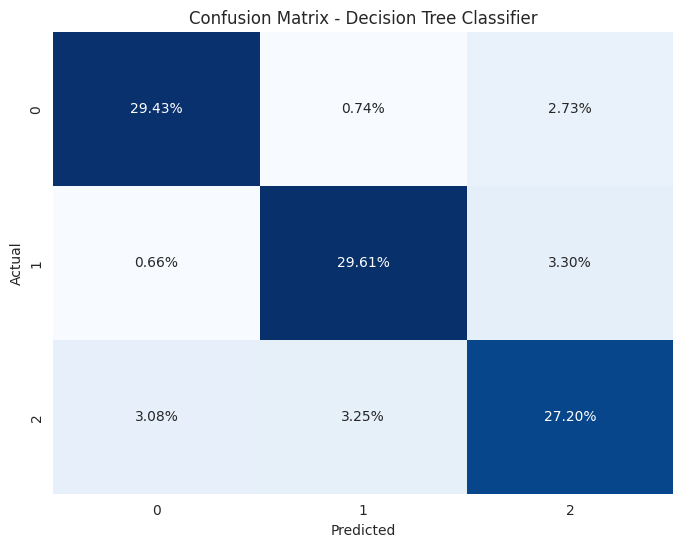

In [55]:
# Plotting the confusion matrix of Decision tree model
DTcm = confusion_matrix(y_test, DTpred)
plt.figure(figsize=(8, 6))
sns.heatmap(DTcm / np.sum(DTcm), annot=True, fmt='.2%', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree Classifier')
plt.show()

In [56]:
# Training and fitting a Random Forest model
RFmodel = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=RF_ESTIMATORS, n_jobs=RF_NJOBS)
RFpipe = Pipeline([('preproc', preprocessor), ('model', RFmodel)])
RFpipe.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Condition', 'Gearbox',
                                                   'Fuel', 'Origin']),
                                                 ('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Year', 'Mileage_winsor',
                                                   'Fiscal Power_parsed',
                                                   'Number of Doors',
                                                   'Brand_freq', 'Model_freq',
                                                   'Location_freq',
                                                   'Sector_freq'])])),
                ('model', RandomForestClassifier(n_jobs=1, random_state=42))])

In [57]:
# Making predictions using trained Random Forest model
RFpred = RFpipe.predict(X_test)

In [58]:
# Displaying the performance of Random Forest model
print("Accuracy of Random Forest Classifier:", accuracy_score(y_test, RFpred)*100)
print("Classification Report:\n", classification_report(y_test, RFpred))

Accuracy of Random Forest Classifier: 88.99681795344164
Classification Report:
               precision    recall  f1-score   support

        High       0.92      0.91      0.91      3929
         Low       0.91      0.91      0.91      4009
      Medium       0.84      0.85      0.85      4004

    accuracy                           0.89     11942
   macro avg       0.89      0.89      0.89     11942
weighted avg       0.89      0.89      0.89     11942



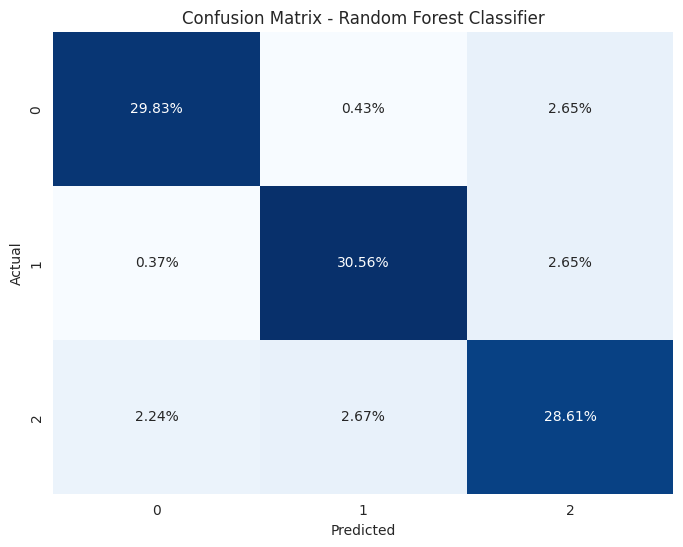

In [59]:
# Plotting the confusion matrix of Random Forest model
RFcm = confusion_matrix(y_test, RFpred)
plt.figure(figsize=(8, 6))
sns.heatmap(RFcm / np.sum(RFcm), annot=True, fmt='.2%', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest Classifier')
plt.show()

In [60]:
# Training and fitting a Gradient Boosting model
GBRmodel = GradientBoostingClassifier(random_state=RANDOM_STATE, n_estimators=GBR_ESTIMATORS)
GBRpipe = Pipeline([('preproc', preprocessor), ('model', GBRmodel)])
GBRpipe.fit(X_train, y_train)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Condition', 'Gearbox',
                                                   'Fuel', 'Origin']),
                                                 ('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Year', 'Mileage_winsor',
                                                   'Fiscal Power_parsed',
                                                   'Number of Doors',
                                                   'Brand_freq', 'Model_freq',
                                                   'Location_freq',
                                                   'Sector_freq'])])),
                ('model', GradientBoostingClassifier(random_state=42))])

In [61]:
# Making predictions using trained Gradient Boosting model
GBRpred = GBRpipe.predict(X_test)

In [62]:
# Displaying the performance of Gradient Boosting model
print("Accuracy of Gradient Boosting Classifier:", accuracy_score(y_test, GBRpred)*100)
print("Classification Report:\n", classification_report(y_test, GBRpred))

Accuracy of Gradient Boosting Classifier: 84.70942890638085
Classification Report:
               precision    recall  f1-score   support

        High       0.88      0.85      0.87      3929
         Low       0.89      0.88      0.89      4009
      Medium       0.77      0.80      0.79      4004

    accuracy                           0.85     11942
   macro avg       0.85      0.85      0.85     11942
weighted avg       0.85      0.85      0.85     11942



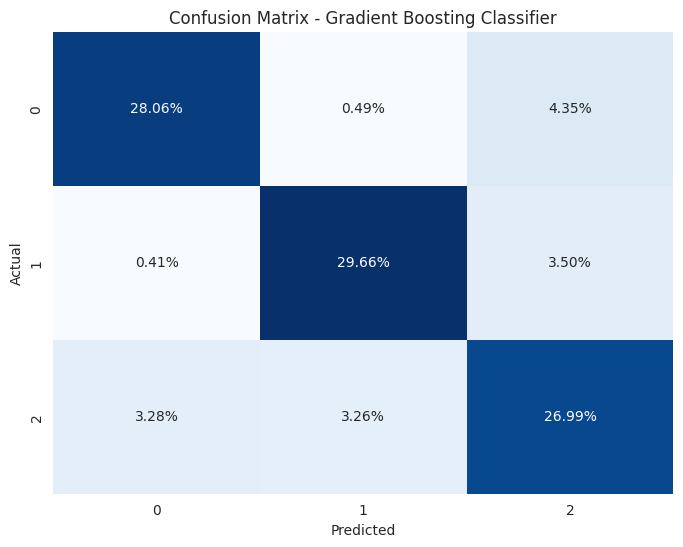

In [63]:
# Plotting the confusion matrix of Gradient Boosting model
GBRcm = confusion_matrix(y_test, GBRpred)
plt.figure(figsize=(8, 6))
sns.heatmap(GBRcm / np.sum(GBRcm), annot=True, fmt='.2%', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Gradient Boosting Classifier')
plt.show()

In [64]:
# Training and fitting a Logistic Regression model
LRmodel = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', multi_class='auto', max_iter=200)
LRpipe = Pipeline([('preproc', preprocessor), ('model', LRmodel)])
LRpipe.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Condition', 'Gearbox',
                                                   'Fuel', 'Origin']),
                                                 ('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Year', 'Mileage_winsor',
                                                   'Fiscal Power_parsed',
                                                   'Number of Doors',
                                                   'Brand_freq', 'Model_freq',
                                                   'Location_freq',
                                                   'Sector_freq'])])),
                ('model',
                 LogisticRegression(max_iter=200, multi_class='auto',
                                    random_state=42, solver='liblinear'))])

In [65]:
# Making predictions using trained Logistic Regression model
LRpred = LRpipe.predict(X_test)

In [66]:
# Displaying the performance of Logistic Regression model
print("Accuracy of Logistic Regression Classifier:", accuracy_score(y_test, LRpred)*100)
print("Classification Report:\n", classification_report(y_test, LRpred, zero_division=0))

Accuracy of Logistic Regression Classifier: 33.570591190755316
Classification Report:
               precision    recall  f1-score   support

        High       0.00      0.00      0.00      3929
         Low       0.34      1.00      0.50      4009
      Medium       0.00      0.00      0.00      4004

    accuracy                           0.34     11942
   macro avg       0.11      0.33      0.17     11942
weighted avg       0.11      0.34      0.17     11942



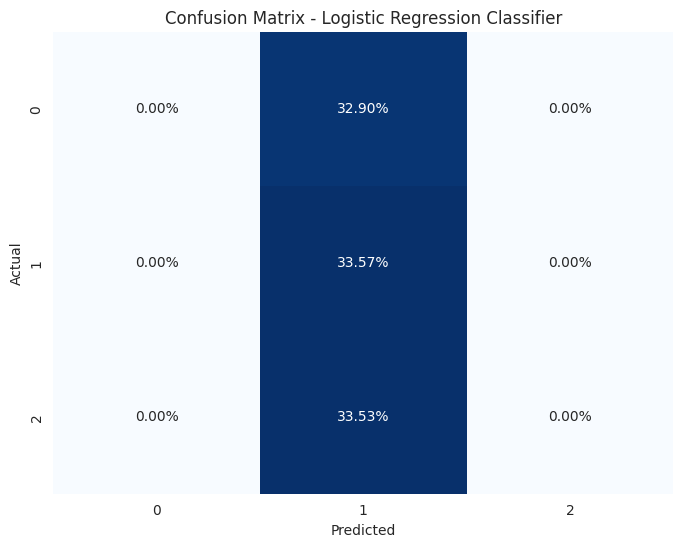

In [67]:
# Plotting the confusion matrix of Logistic Regression model
LRcm = confusion_matrix(y_test, LRpred)
plt.figure(figsize=(8, 6))
sns.heatmap(LRcm / np.sum(LRcm), annot=True, fmt='.2%', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression Classifier')
plt.show()

In [68]:
# Defining a function to extract metrics programmatically
def extract_metrics(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    metrics = {
        'Model': model_name,
        'Accuracy': report['accuracy'] * 100,
        'High_Precision': report['High']['precision'],
        'High_Recall': report['High']['recall'],
        'High_F1-score': report['High']['f1-score'],
        'Low_Precision': report['Low']['precision'],
        'Low_Recall': report['Low']['recall'],
        'Low_F1-score': report['Low']['f1-score'],
        'Medium_Precision': report['Medium']['precision'],
        'Medium_Recall': report['Medium']['recall'],
        'Medium_F1-score': report['Medium']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1-score': report['weighted avg']['f1-score']
    }
    return metrics

In [69]:
# Collect metrics for each model
model_metrics = []
model_metrics.append(extract_metrics(y_test, DTpred, 'Decision Tree'))
model_metrics.append(extract_metrics(y_test, RFpred, 'Random Forest'))
model_metrics.append(extract_metrics(y_test, GBRpred, 'Gradient Boosting'))
model_metrics.append(extract_metrics(y_test, LRpred, 'Logistic Regression'))

In [70]:
# Creating a metrics dataframe
metrics_df = pd.DataFrame(model_metrics)

In [71]:
# Printing Model Performance Metrics
display(metrics_df.T)

,0,1,2,3
Model,Decision Tree,Random Forest,Gradient Boosting,Logistic Regression
Accuracy,86.241836,88.996818,84.709429,33.570591
High_Precision,0.887178,0.919463,0.883703,0.0
High_Recall,0.89463,0.906592,0.852889,0.0
High_F1-score,0.890888,0.912982,0.868022,0.0
Low_Precision,0.881356,0.907937,0.887719,0.335706
Low_Recall,0.882015,0.910202,0.883512,1.0
Low_F1-score,0.881686,0.909068,0.885611,0.502664
Medium_Precision,0.818548,0.843912,0.77476,0.0
Medium_Recall,0.811189,0.853397,0.804945,0.0


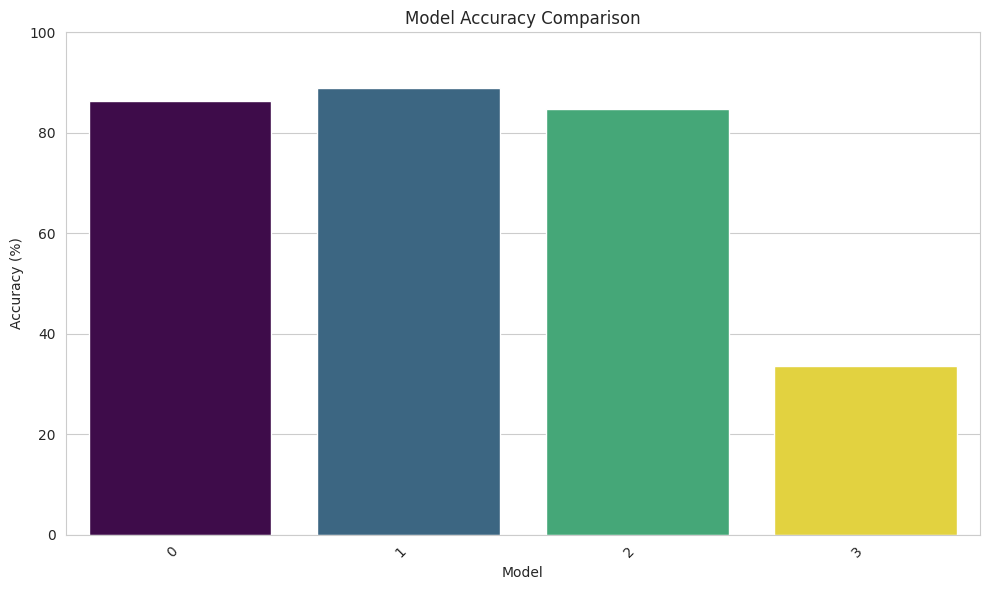

In [72]:
# Visualising the accuracy scores of the models
plt.figure(figsize=(10, 6))
sns.barplot(x=metrics_df.index, y=metrics_df['Accuracy'], hue=metrics_df.index, palette='viridis', legend=False)
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100) # Accuracy is a percentage so limiting y-axis from 0 to 100
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [73]:
# Identifying the best performing model
best_model = max(model_metrics, key=lambda k: k['Accuracy'])
print("Best performing model:", best_model['Model'])

Best performing model: Random Forest


In [74]:
# Creating a DataFrame to compare actual vs predicted values
comparison_df = pd.DataFrame({
    'Actual Price Category': y_test,
    'Predicted Price Category': RFpred})

In [75]:
# Display the first few rows of the comparison
display(comparison_df.head(10))

,Actual Price Category,Predicted Price Category
12753,Medium,Medium
66827,High,High
27705,High,High
95875,High,High
44339,High,High
77601,Low,Low
79419,High,High
77771,Medium,Medium
12308,High,High
11687,Medium,Medium


In [76]:
# Extract feature importances from the best performing model
rf_model = RFpipe.named_steps['model']
feature_importances = rf_model.feature_importances_

In [77]:
# Get feature names from OneHotEncoder
ohe_feature_names = preprocessor.named_transformers_['ohe'].get_feature_names_out(ohe_cols)

In [78]:
# Get feature names for numerical columns
num_feature_names = num_cols

In [79]:
# Combining all feature names
all_feature_names = list(ohe_feature_names) + list(num_feature_names)

In [80]:
# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': feature_importances})

In [81]:
# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [82]:
# Printing Feature Importances from Random Forest Model
display(feature_importance_df.head(10))

,Feature,Importance
18,Year,0.327615
23,Model_freq,0.098668
19,Mileage_winsor,0.080273
7,Gearbox_Automatic,0.075046
22,Brand_freq,0.068266
8,Gearbox_Manual,0.064540
25,Sector_freq,0.058999
20,Fiscal Power_parsed,0.058300
24,Location_freq,0.051757
13,Fuel_Petrol,0.025846


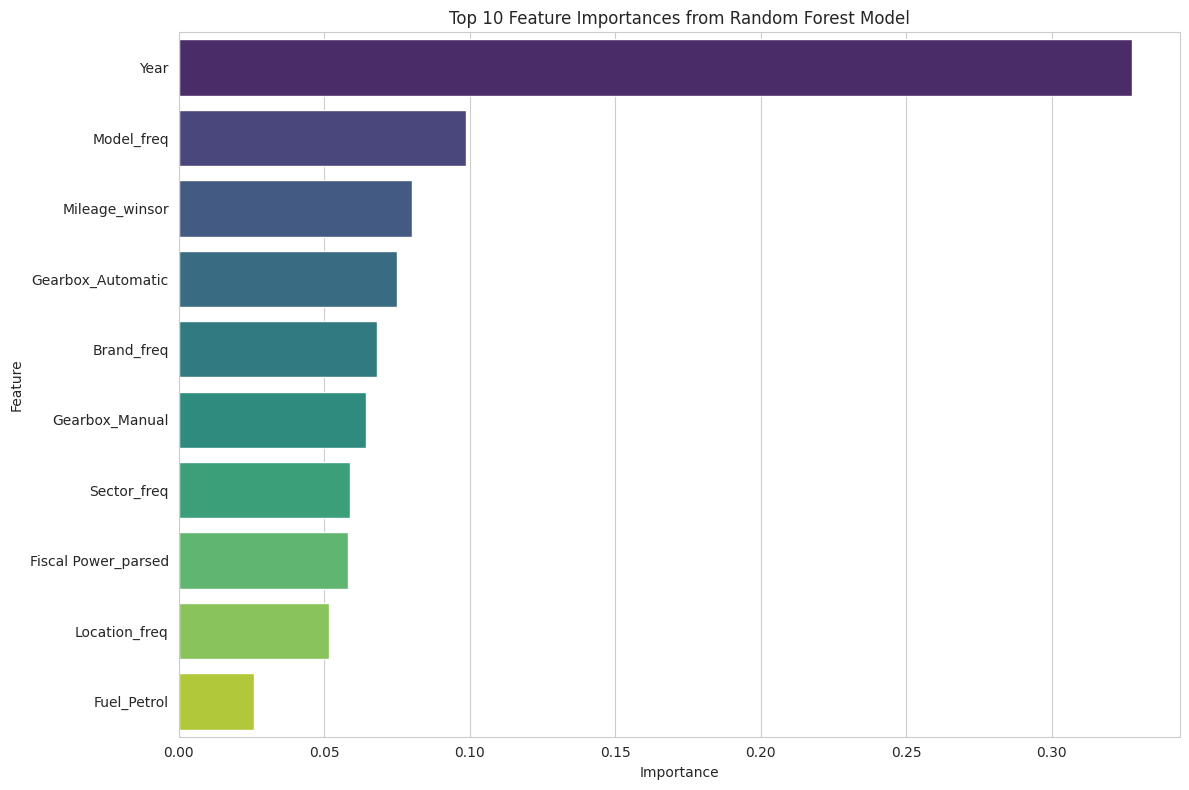

In [83]:
# Visualising which features are most influential in predicting car prices
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis', hue='Feature', legend=False)
plt.title('Top 10 Feature Importances from Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [84]:
# Splitting the original feature DataFrame X and target Series y into training and testing sets
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y)

In [85]:
# Creating the frequency maps for high-cardinality columns
frequency_maps = {}
for col in high_card:
    frequency_maps[col] = X_train_orig[col].value_counts(normalize=True)

In [86]:
# Defining the predict_price_category function
def predict_price_category(car_features_dict):
    input_df = pd.DataFrame([car_features_dict])
    for col in high_card:
        if col in input_df.columns:
            input_df[col + '_freq'] = input_df[col].map(frequency_maps[col]).fillna(0)
            input_df.drop(columns=[col], inplace=True)
        else:
            input_df[col + '_freq'] = 0.0

    # Predicting price category using the RFpipe model
    prediction = RFpipe.predict(input_df)
    return prediction[0]

In [ ]:
# Usage with an dictionary of car features
sample_car_features = {
    'Brand': 'Volkswagen',
    'Model': 'Polo',
    'Year': 2018.0,
    'Condition': 'Very Good',
    'Mileage_winsor': 50000.0,
    'Gearbox': 'Manual',
    'Fiscal Power_parsed': 6.0,
    'Fuel': 'Diesel',
    'Number of Doors': 5.0,
    'Origin': 'WW in Morocco',
    'Location': 'Casablanca',
    'Sector': 'City Center'
}

In [87]:
# Display predicted price category
predicted_category = predict_price_category(sample_car_features)
print(f"The predicted price category for the sample car is: {predicted_category}")

The predicted price category for the sample car is: Medium
